In [1]:
#Name: Xin Chen
#Github Username: Leo-ChenX
#USC ID: 9398145983

import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn import datasets
from sklearn import tree
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

1. Decision Trees as Interpretable Models

(a) Download the Accute In
amations data from https://archive.ics.uci.edu/
ml/datasets/Acute+Inflammations.

In [2]:
data = pd.read_csv("../data/diagnosis.data", na_values='?', header = None, encoding='UTF_16', delimiter='\t', decimal = ',')
data = data.replace({'no': '0'}, regex=True)
data = data.replace({'yes': '1'}, regex=True)

feature_names = ["a1 Temperature of patient { 35C-42C }",
"a2 Occurrence of nausea { yes, no }",
"a3 Lumbar pain { yes, no }",
"a4 Urine pushing (continuous need for urination) { yes, no }",
"a5 Micturition pains { yes, no }",
"a6 Burning of urethra, itch, swelling of urethra outlet { yes, no }"]

class_names = ["d1 decision: Inflammation of urinary bladder { yes, no }",
"d2 decision: Nephritis of renal pelvis origin { yes, no }" ]

print(feature_names)
print(class_names)

['a1 Temperature of patient { 35C-42C }', 'a2 Occurrence of nausea { yes, no }', 'a3 Lumbar pain { yes, no }', 'a4 Urine pushing (continuous need for urination) { yes, no }', 'a5 Micturition pains { yes, no }', 'a6 Burning of urethra, itch, swelling of urethra outlet { yes, no }']
['d1 decision: Inflammation of urinary bladder { yes, no }', 'd2 decision: Nephritis of renal pelvis origin { yes, no }']


(b) Build a decision tree on the whole data set and plot it.1

In [3]:
X = data.iloc[:, 0:6]
y = data.iloc[:, 6:]

print(X)
print(y)
# Build decision tree classifier
dt = tree.DecisionTreeClassifier(criterion='entropy')
dt.fit(X, y)

dotfile = open("dt.dot", 'w')
tree.export_graphviz(dt, out_file=dotfile, feature_names = feature_names)
dotfile.close()


text_representation = tree.export_text(dt, feature_names = feature_names)

        0  1  2  3  4  5
0    35.5  0  1  0  0  0
1    35.9  0  0  1  1  1
2    35.9  0  1  0  0  0
3    36.0  0  0  1  1  1
4    36.0  0  1  0  0  0
..    ... .. .. .. .. ..
115  41.4  0  1  1  0  1
116  41.5  0  0  0  0  0
117  41.5  1  1  0  1  0
118  41.5  0  1  1  0  1
119  41.5  0  1  1  0  1

[120 rows x 6 columns]
     6  7
0    0  0
1    1  0
2    0  0
3    1  0
4    0  0
..  .. ..
115  0  1
116  0  0
117  0  1
118  0  1
119  0  1

[120 rows x 2 columns]


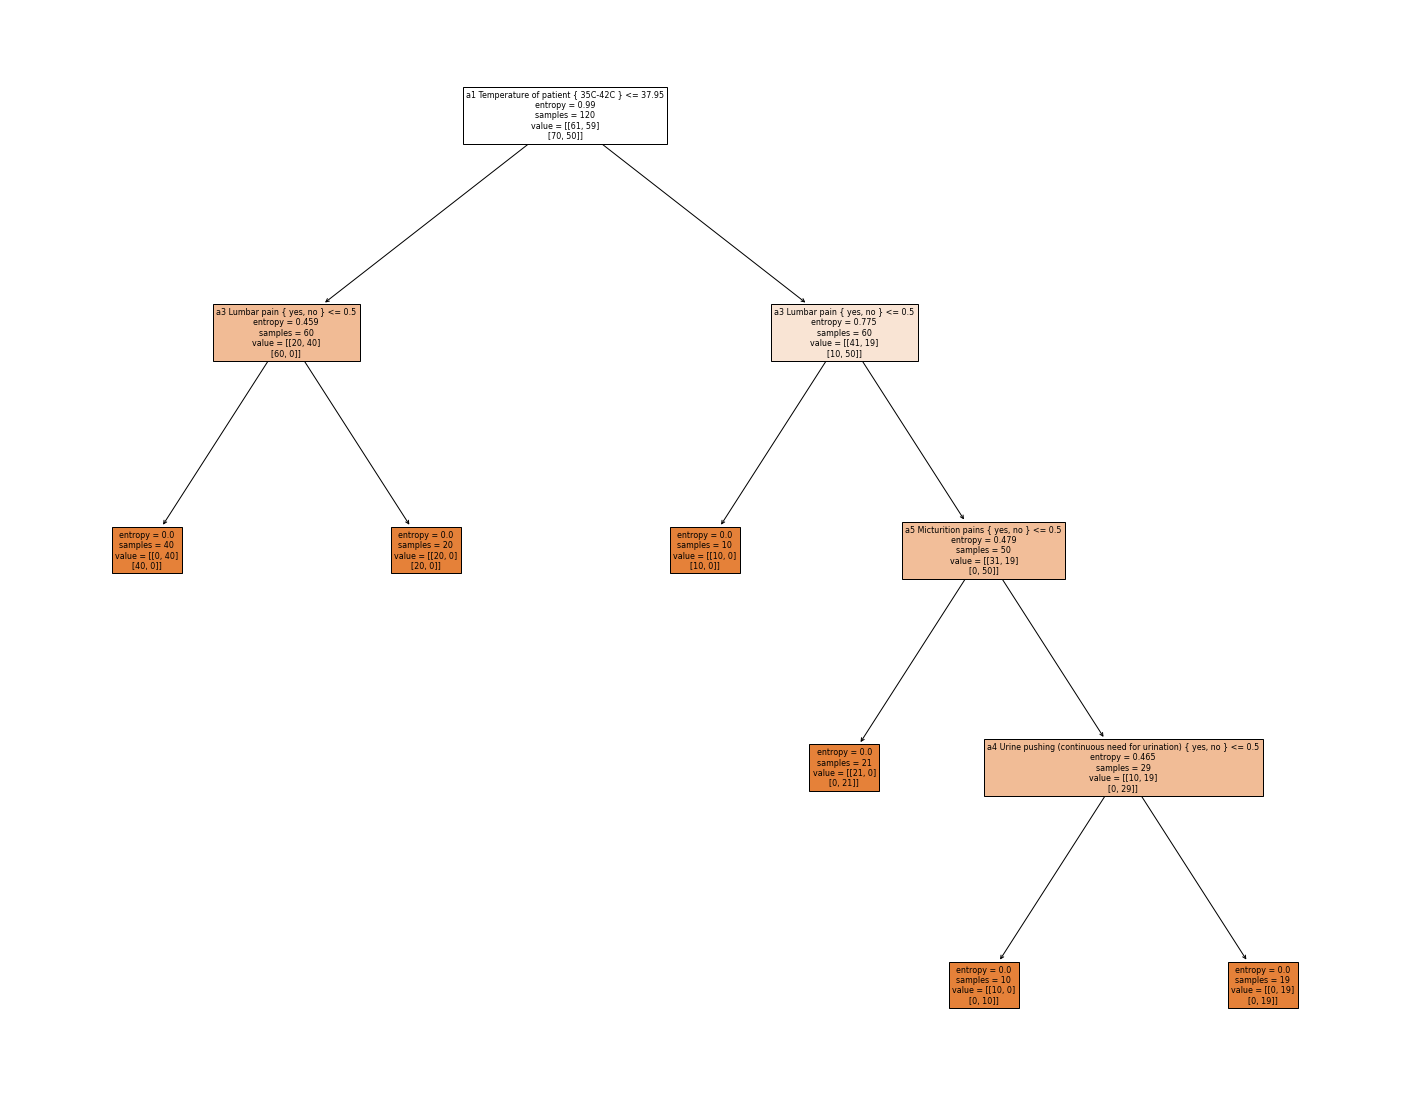

In [4]:
with open("decistion_tree.log", "w") as fout:
    fout.write(text_representation)
    
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   feature_names = feature_names,  
                   class_names = class_names,
                   filled=True)

(c) Convert the decision rules into a set of IF-THEN rules.2

In [5]:
def tree_to_pseudo(tree, feature_names):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value
    def recurse(left, right, threshold, features, node, depth=0):
        indent = " " * depth
        if (threshold[node] != -2):
            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
        if left[node] != -1:
            recurse (left, right, threshold, features, left[node], depth+1)
            print(indent,"} else {")
        if right[node] != -1:
            recurse (left, right, threshold, features, right[node], depth+1)
            print(indent,"}")
        else:
            print(indent,"return " + str(value[node]))
            recurse(left, right, threshold, features, 0)

            
            
def tree_to_code(tree, feature_names):            
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))
    def recurse(node, depth):
        indent = " " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else: # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))
    recurse(0, 1)



tree_to_code(dt, feature_names)
tree_to_pseudo(dt, feature_names)

def tree(a1 Temperature of patient { 35C-42C }, a2 Occurrence of nausea { yes, no }, a3 Lumbar pain { yes, no }, a4 Urine pushing (continuous need for urination) { yes, no }, a5 Micturition pains { yes, no }, a6 Burning of urethra, itch, swelling of urethra outlet { yes, no }):
 if a1 Temperature of patient { 35C-42C } <= 37.95000076293945:
  if a3 Lumbar pain { yes, no } <= 0.5:
   return [[ 0. 40.]
 [40.  0.]]
  else: # if a3 Lumbar pain { yes, no } > 0.5
   return [[20.  0.]
 [20.  0.]]
 else: # if a1 Temperature of patient { 35C-42C } > 37.95000076293945
  if a3 Lumbar pain { yes, no } <= 0.5:
   return [[10.  0.]
 [10.  0.]]
  else: # if a3 Lumbar pain { yes, no } > 0.5
   if a5 Micturition pains { yes, no } <= 0.5:
    return [[21.  0.]
 [ 0. 21.]]
   else: # if a5 Micturition pains { yes, no } > 0.5
    if a4 Urine pushing (continuous need for urination) { yes, no } <= 0.5:
     return [[10.  0.]
 [ 0. 10.]]
    else: # if a4 Urine pushing (continuous need for urination) { yes, 

(d) Use cost-complexity pruning to find a minimal decision tree and a set of decision
rules with high interpretability.

In [6]:
trainX, testX, trainY, testY = train_test_split(X, y, test_size = .20, random_state = 45)

tree = DecisionTreeClassifier(random_state = 40)
tree.fit(trainX, trainY)

trainPredict = tree.predict(trainX)
testPredict = tree.predict(testX)


mseTrain = MSE(testY, testPredict)
mseTest = MSE(testY, testPredict)
print(mseTest)
print(mseTrain)

0.0
0.0


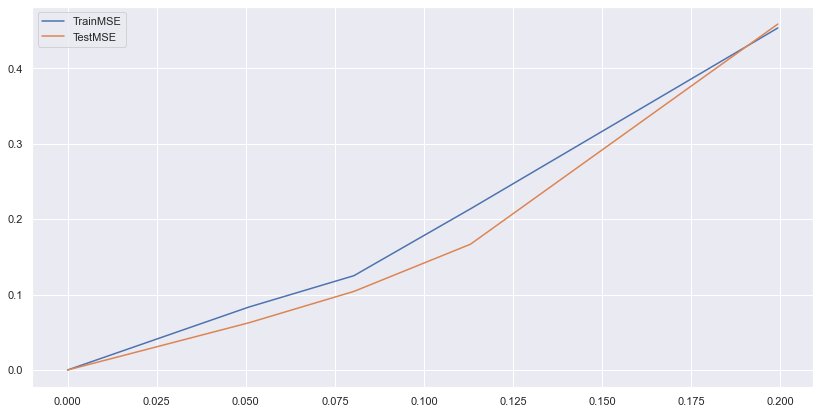

[0.0, 0.08333333333333333, 0.125, 0.21354166666666666, 0.453125]
[0.0, 0.0625, 0.10416666666666666, 0.16666666666666666, 0.4583333333333333]


In [7]:
path = tree.cost_complexity_pruning_path(trainX, trainY)
alphas = path['ccp_alphas']

MSE_train, MSE_test = [], []

for alpha in alphas:
    tree = DecisionTreeClassifier(ccp_alpha = alpha)
    tree.fit(trainX, trainY)
    trainPredict = tree.predict(trainX)
    testPredict = tree.predict(testX)
    
    MSE_train.append(MSE(trainY, trainPredict))
    MSE_test.append(MSE(testY, testPredict))

sns.set()
plt.figure(figsize = (14,7))
sns.lineplot(y = MSE_train, x = alphas, label = 'TrainMSE')
sns.lineplot(y = MSE_test, x = alphas, label = 'TestMSE')

plt.show()

print(MSE_train)
print(MSE_test)

From the above plot, we can see that when alpha is very low, close to 0, we get the lowest MSE.

2. The LASSO and Boosting for Regression

(a) Download the Communities and Crime data3 from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as
the training set and the rest as the test set.

In [8]:
data = pd.read_csv("../data/communities.data", na_values='?', header = None)
trainSet = data[0:1495]
testSet = data[1495:]

print(trainSet)
print(testSet)

      0     1        2                    3    4     5     6     7     8    \
0       8   NaN      NaN         Lakewoodcity    1  0.19  0.33  0.02  0.90   
1      53   NaN      NaN          Tukwilacity    1  0.00  0.16  0.12  0.74   
2      24   NaN      NaN         Aberdeentown    1  0.00  0.42  0.49  0.56   
3      34   5.0  81440.0  Willingborotownship    1  0.04  0.77  1.00  0.08   
4      42  95.0   6096.0    Bethlehemtownship    1  0.01  0.55  0.02  0.95   
...   ...   ...      ...                  ...  ...   ...   ...   ...   ...   
1490    6   NaN      NaN     Hillsboroughtown    8  0.00  0.59  0.01  0.69   
1491    6   NaN      NaN           Orangecity    8  0.16  0.62  0.03  0.74   
1492   13   NaN      NaN         Waycrosscity    8  0.01  0.36  0.95  0.24   
1493   39  85.0  49056.0           Mentorcity    8  0.06  0.53  0.01  0.98   
1494   34  17.0  79610.0      WestNewYorktown    8  0.05  0.43  0.08  0.65   

       9    ...   118   119   120   121   122   123  124   125 

(b) The data set has missing values. Use a data imputation technique to deal with
the missing values in the data set. The data description mentions some features
are nonpredictive. Ignore those features.

In [9]:
# As there are a lot missing values in the first 5 cols, we delete them to be predictive. Then, we use mean to replace unknown data (?)
data = data.iloc[:, 5:]
imputer = SimpleImputer(missing_values = np.nan, strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data))

trainSet = data[0:1495]
testSet = data[1495:]

trainX = trainSet.iloc[:, :-1]
trainY = trainSet.iloc[:, -1]

testX = testSet.iloc[:, :-1]
testY = testSet.iloc[:, -1]


print(trainY)
print(testY)

0       0.20
1       0.67
2       0.43
3       0.12
4       0.03
        ... 
1490    0.03
1491    0.20
1492    0.30
1493    0.03
1494    0.23
Name: 122, Length: 1495, dtype: float64
1495    0.12
1496    0.11
1497    0.12
1498    0.06
1499    0.12
        ... 
1989    0.09
1990    0.45
1991    0.23
1992    0.19
1993    0.48
Name: 122, Length: 499, dtype: float64


(c) Plot a correlation matrix for the features in the data set.

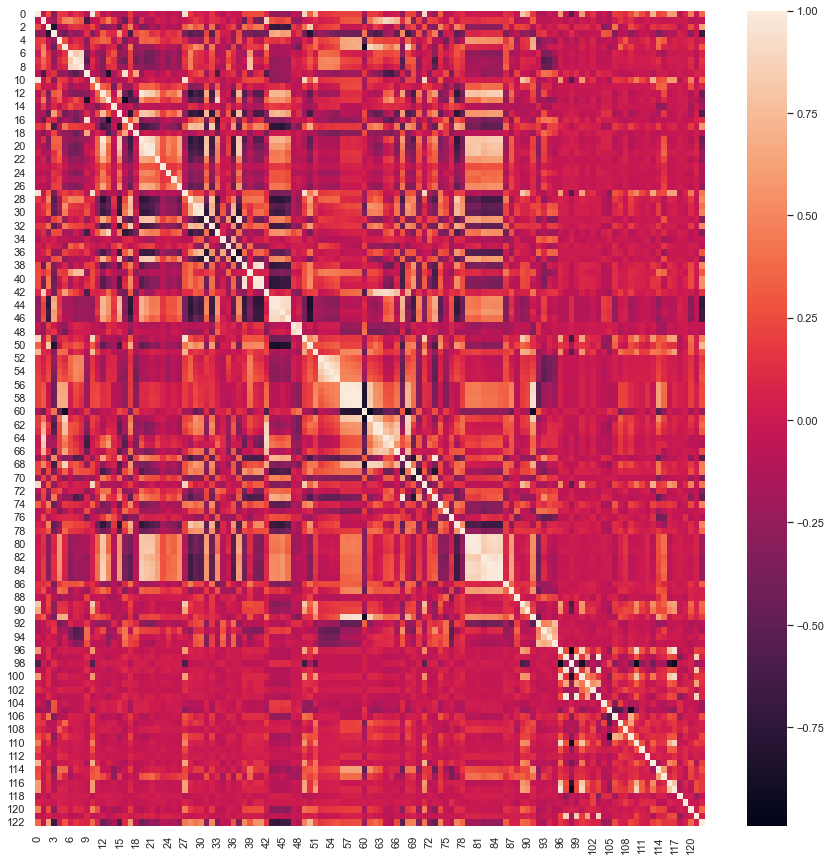

In [10]:
cor = data.corr()
fit, axes = plt.subplots(figsize=(15, 15))
sns.heatmap(cor, ax=axes)
plt.show()


(d) Calculate the Coefficient of Variation CV for each feature, where CV = s
m, in
which s is sample standard deviation and m is sample mean..

In [11]:
cv = data.apply(lambda col : col.std() / col.mean(), axis=0)
print(cv)

0      2.203503
1      0.353298
2      1.410920
3      0.323782
4      1.359162
         ...   
118    0.122331
119    0.368040
120    2.555266
121    0.337281
122    0.979015
Length: 123, dtype: float64


(e) Pick b
p
128c features with highest CV , and make scatter plots and box plots for
them. Can you draw conclusions about signicance of those features, just by the
scatter plots?

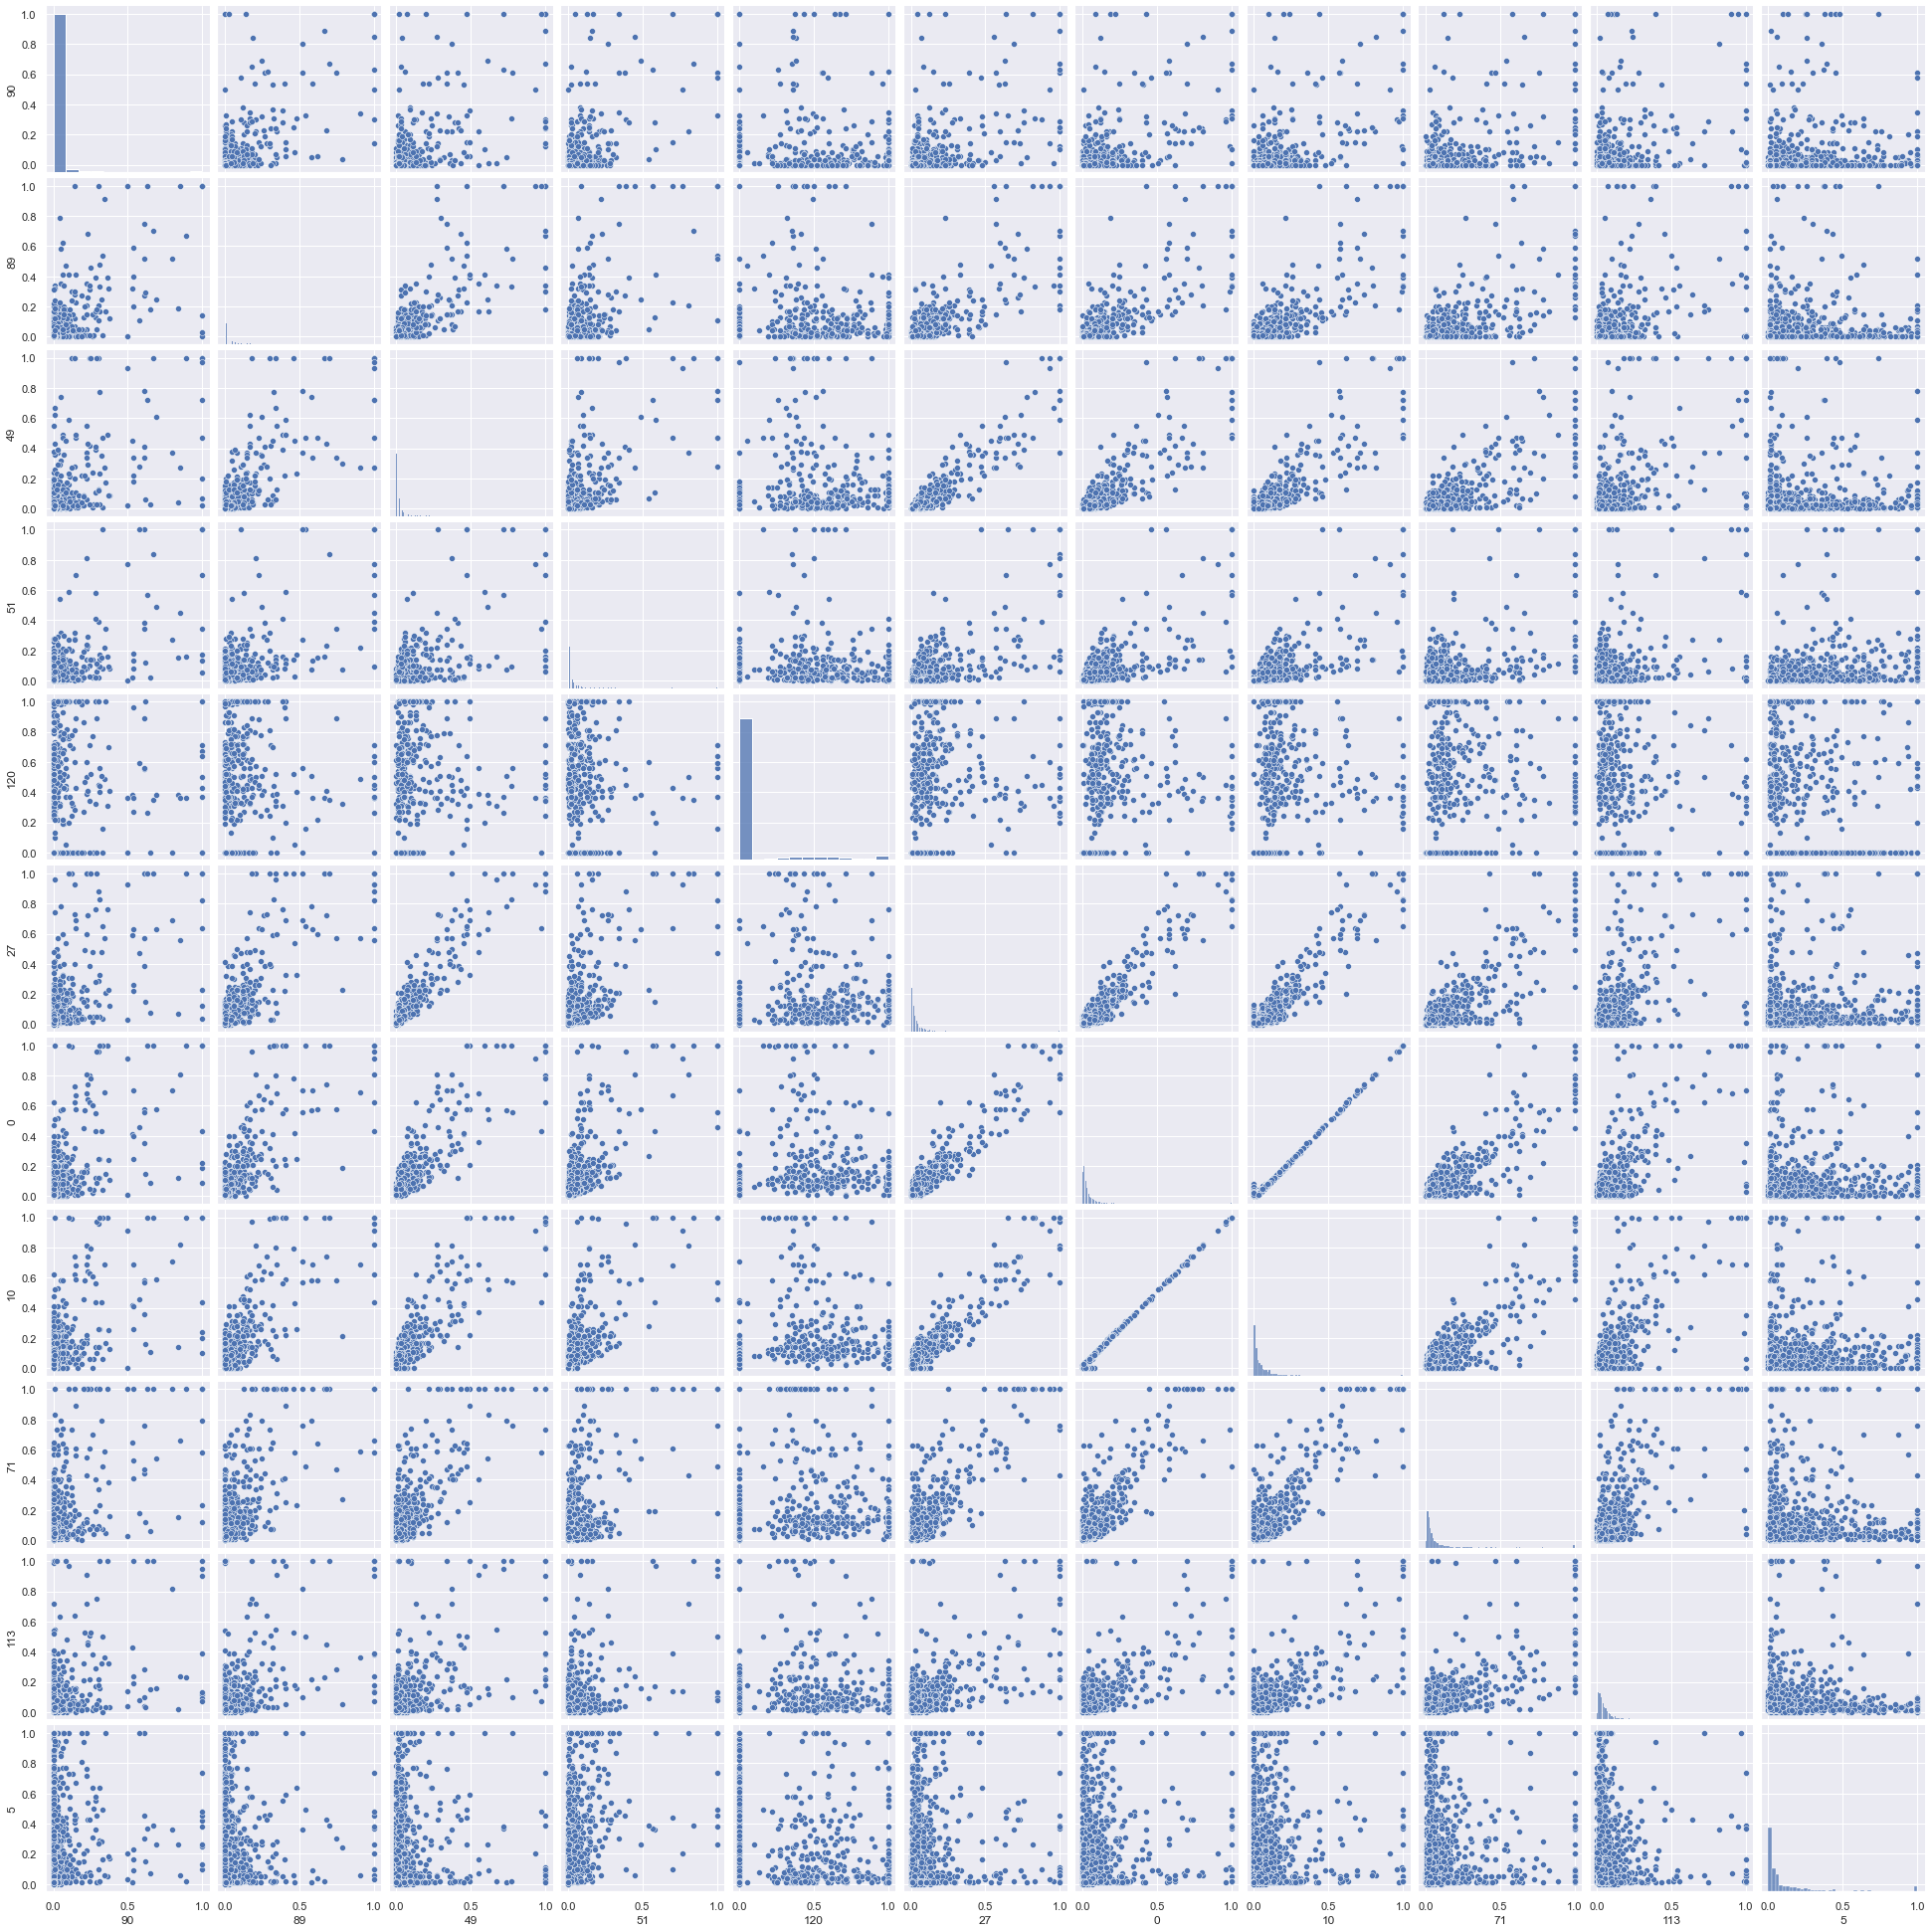

In [12]:
n = int(np.sqrt(128))
featuresCV = cv.sort_values(ascending=False)[:n]
sns.pairplot(data[featuresCV.index.tolist()])
plt.show()

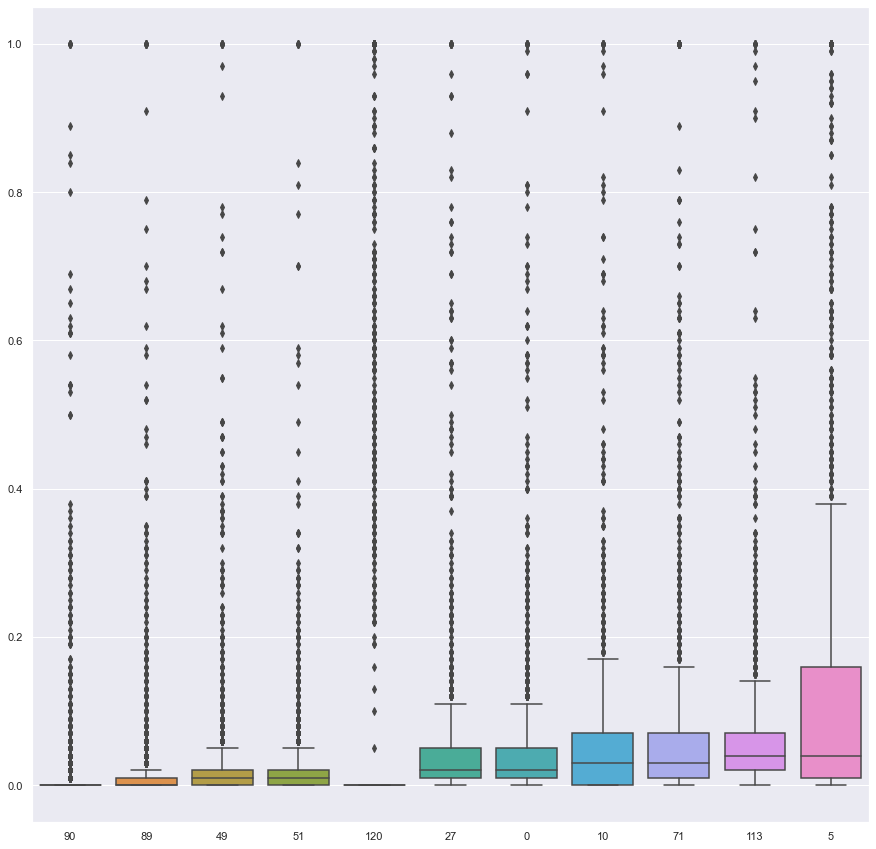

In [13]:
fig, axes = plt.subplots(figsize=(15, 15))
sns.boxplot(data = data[featuresCV.index.tolist()], ax=axes)
plt.show()

By the scatter plots and box plots, we cannot take difference between the siginificance of these features

(f) Fit a linear model using least squares to the training set and report the test error.

In [14]:
lm = LinearRegression().fit(trainX, trainY)
leastSquare = lm.score(testX,testY)
mse = MSE(testY, lm.predict(testX))
print('Least Squares:', leastSquare)
print('MSE:', mse)

Least Squares: -15.606466950721273
MSE: 0.7897255274320215


(g) Fit a ridge regression model on the training set, with  chosen by cross-validation.
Report the test error obtained.

In [15]:
alphas = [10 ** i for i in range(-5, 6)]
rm = RidgeCV(alphas = alphas, cv = 5, normalize= False).fit(trainX, trainY)
leastSquare = rm.score(testX,testY)
mse = MSE(testY,rm.predict(testX))

print('Ramuda: ', rm.alpha_)
print('Least Squares:', leastSquare)
print('MSE:', mse)

Ramuda:  1.0
Least Squares: 0.6270219957069374
MSE: 0.01773708110430366


(h) Fit a LASSO model on the training set, with  chosen by cross-validation. Report
the test error obtained, along with a list of the variables selected by the model.
Repeat with standardized4 features. Report the test error for both cases and
compare them.

In [16]:
lasso = LassoCV(alphas = alphas, cv = 5, random_state=0).fit(trainX, trainY)
leastSquare = lasso.score(testX,testY)
mse = MSE(testY,lasso.predict(testX))

selectedFeatures = trainX.iloc[:, lasso.coef_ != 0]

print('Before standarized:')
print('Ramuda: ', lasso.alpha_)
print('Least Squares:', leastSquare)
print('MSE:', mse)
print('Selected features index: ', list(selectedFeatures.columns))

Before standarized:
Ramuda:  0.0001
Least Squares: 0.6259053074097357
MSE: 0.017790185551932514
Selected features index:  [2, 4, 6, 7, 9, 11, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 28, 29, 31, 33, 34, 36, 38, 39, 40, 44, 45, 46, 48, 49, 50, 51, 55, 59, 61, 63, 64, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 82, 85, 86, 87, 88, 89, 90, 91, 94, 99, 100, 102, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120]


In [17]:
scaler = preprocessing.StandardScaler()

trainXSD = scaler.fit_transform(trainX)
testXSD = scaler.fit_transform(testX)

lasso = LassoCV(alphas = alphas, cv = 5, random_state=0).fit(trainXSD, trainY)
leastSquare = lasso.score(testXSD,testY)
mse = MSE(testY,lasso.predict(testXSD))

print('After standarized:')
print('Ramuda: ', lasso.alpha_)
print('Least Squares:', leastSquare)
print('MSE:', mse)

After standarized:
Ramuda:  0.001
Least Squares: 0.622438475885954
MSE: 0.01795505176711006


After comparing these two results, we found that their error rate is close, so no siginificant difference. However, standardized lasso has lower MSE, so it may be better.

(i) Fit a PCR model on the training set, with M (the number of principal compo-
nents) chosen by cross-validation. Report the test error obtained.

In [18]:
globalM = 0
globalMSE = 1

for i in range(1, len(testX.columns) + 1):
    lr = LinearRegression()
    pca = PCA(n_components = i)
    reducedX = pca.fit_transform(trainX)
    scores = cross_validate(lr, reducedX, trainY, cv=3, scoring=('r2', 'neg_mean_squared_error'))
    mse = -1 * (np.mean(scores['test_neg_mean_squared_error']))
    
    if mse < globalMSE:
        globalMSE = mse
        globalM = i

        
print("We choose M: ", globalM)
print("MSE: ", globalMSE)

We choose M:  67
MSE:  0.019645233635113016


(j) In this section, we would like to fit a boosting tree to the data. As in classification
trees, one can use any type of regression at each node to build a multivariate
regression tree. Because the number of variables is large in this problem, one
can use L1-penalized regression at each node. Such a tree is called L1 penalized
gradient boosting tree. You can use XGBoost5 to fit the model tree. Determine
 (the regularization term) using cross-validation.
5Some

In [19]:
trainX_matrix = xgb.DMatrix(data = trainX, label = trainY)
testX_matrix = xgb.DMatrix(data = testX)
alphas = [10 ** i for i in range(-10, 11)]


for alpha in alphas:
    xgbModel = xgb.XGBRegressor(objective = "reg:squarederror", reg_alpha = alpha)
    cv = cross_val_score(xgbModel, trainX, trainY, cv = 5, scoring = "neg_mean_squared_error")
    print("Alpha: ", alpha)
    print("MSE: ", np.abs(cv.mean()))


Alpha:  1e-10
MSE:  0.023105680766831598
Alpha:  1e-09
MSE:  0.02310568083734944
Alpha:  1e-08
MSE:  0.023270899967929817
Alpha:  1e-07
MSE:  0.023105680408254968
Alpha:  1e-06
MSE:  0.02311293568621384
Alpha:  1e-05
MSE:  0.023300586119074804
Alpha:  0.0001
MSE:  0.023282656533149017
Alpha:  0.001
MSE:  0.023353732805068233
Alpha:  0.01
MSE:  0.022779196486180518
Alpha:  0.1
MSE:  0.02276400556084081
Alpha:  1
MSE:  0.02126884498239453
Alpha:  10
MSE:  0.022048766979410016
Alpha:  100
MSE:  0.037433587590192496
Alpha:  1000
MSE:  0.12374709030100335
Alpha:  10000
MSE:  0.12374709030100335
Alpha:  100000
MSE:  0.12374709030100335
Alpha:  1000000
MSE:  0.12374709030100335
Alpha:  10000000
MSE:  0.12374709030100335
Alpha:  100000000
MSE:  0.12374709030100335
Alpha:  1000000000
MSE:  0.12374709030100335
Alpha:  10000000000
MSE:  0.12374709030100335


Best
Alpha:  0.1

MSE:  0.02276400556084081